In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import utils

import colorsys
from os import replace
import random
import skimage.draw as drw

# ROOT_DIR = 'C:/Users/Federico/Downloads/PAPILA/PapilaDB-PAPILA/'
ROOT_DIR = '../'

Gender (Masculino =0, Femenino =1)
Diagnosis(saludable =0, Glaucoma=1, Sospechar=2)

In [4]:
def _fix_df(df):
    """Prepare el data frame para que sea legible"""
    df_new = df.drop(['ID'], axis=0)
    df_new.columns = df_new.iloc[0,:]
    df_new.drop([np.nan], axis=0, inplace=True)
    df_new.columns.name = 'ID'
    return df_new
    
def read_clinical_data(abs_path):
    """Devolver datos de Excel como data frame de pandas"""
    df_od = pd.read_excel(abs_path + 'ClinicalData/patient_data_od.xlsx', index_col=[0])
    df_os = pd.read_excel(abs_path + 'ClinicalData/patient_data_os.xlsx', index_col=[0])
    return _fix_df(df=df_od), _fix_df(df=df_os)

def get_diagnosis(abs_path='../'):
    """Devuelva tres arrays con shape 488 con diagnóstico tag, ID de ojo (od, os)
     y la identificación del paciente"""
    df_od, df_os = read_clinical_data(abs_path=abs_path)
        
    index_od = np.ones(df_od.iloc[:,2].values.shape, dtype=np.int8)
    index_os = np.zeros(df_os.iloc[:,2].values.shape, dtype=np.int8)

    eyeID = np.array(list(zip(index_od, index_os))).reshape(-1)
    tag = np.array(list(zip(df_od.iloc[:,2].values, df_os.iloc[:,2].values))).reshape(-1)
    patID = np.array([[int(i.replace('#', ''))] * 2 for i in df_od.index]).reshape(-1)
    
    return tag, eyeID, patID

### Leer datos clínicos

In [5]:
df_ojo_der, df_ojo_izq = read_clinical_data(ROOT_DIR)

In [6]:
df_ojo_der.head()

ID,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD
#002,47,0,2,0.75,-1.75,90,0,21,NaN,586,23.64,-0.07
#004,58,1,1,1.5,-1.75,85,0,NaN,19,501,23.06,-3.26
#005,89,1,1,-0.75,-1.25,101,1,13,14,565,23.81,-14.98
#006,69,0,2,1,-1.5,95,0,22,NaN,612,26.25,-2.07
#007,22,1,2,-0.25,0,0,0,14,NaN,NaN,23.39,-2.3


In [7]:
df_ojo_izq.head()

ID,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD
#002,47,0,2,-0.5,-1.5,88,0,20,NaN,603,23.77,0.17
#004,58,1,1,1.5,-2.5,85,1,NaN,19,511,22.96,-6.77
#005,89,1,1,-0.5,-2,100,1,24,10,575,24.33,-7.44
#006,69,0,2,1,-1.5,85,0,22,NaN,593,26.21,-3.31
#007,22,1,2,-0.25,-0.5,0,0,13,NaN,NaN,23.35,-2.61


In [8]:
df_ojo_izq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, #002 to #293
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  244 non-null    object
 1   Gender               244 non-null    object
 2   Diagnosis            244 non-null    object
 3   dioptre_1            232 non-null    object
 4   dioptre_2            239 non-null    object
 5   astigmatism          239 non-null    object
 6   Phakic/Pseudophakic  238 non-null    object
 7   Pneumatic            199 non-null    object
 8   Perkins              64 non-null     object
 9   Pachymetry           237 non-null    object
 10  Axial_Length         240 non-null    object
 11  VF_MD                82 non-null     object
dtypes: object(12)
memory usage: 24.8+ KB


### Leer etiquetas de diagnóstico
Devuelve tres matrices de tamaño 488: etiqueta de diagnóstico, ID de ojo e ID de paciente.

In [9]:
y, eyeID, patID = utils.get_diagnosis(ROOT_DIR)

AttributeError: module 'utils' has no attribute 'get_diagnosis'

### Leer contornos para transformar en máscaras binarias

In [8]:
#%% 
# contour_to_mask() and apply_mask() functions taken from https://github.com/matterport/Mask_RCNN
def contour_to_mask(cont, img_shape, abs_path='../'):
    """Return mask given a contour and the shape of image"""
    c = np.loadtxt(abs_path + "ExpertsSegmentations/Contours/" + cont)
    mask = np.zeros(img_shape[:-1], dtype=np.uint8)
    rr, cc = drw.polygon(c[:,1], c[:,0])
    mask[rr, cc] = 1
    return mask

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image."""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image
# %%

RET002OD_cup_exp1.txt
Mask shape (1934, 2576)


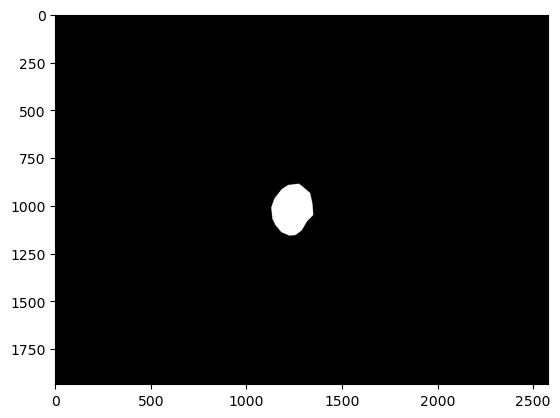

In [9]:
cont = os.listdir(ROOT_DIR + "ExpertsSegmentations/Contours/")[0] # getting file name
print(cont)
img_shape = (1934, 2576, 3) # passing a image shape
# getting mask
mask = contour_to_mask(cont=cont, img_shape=img_shape, abs_path=ROOT_DIR)
print('Mask shape {}'.format(mask.shape))
plt.imshow(mask, cmap='gray') # plotting mask

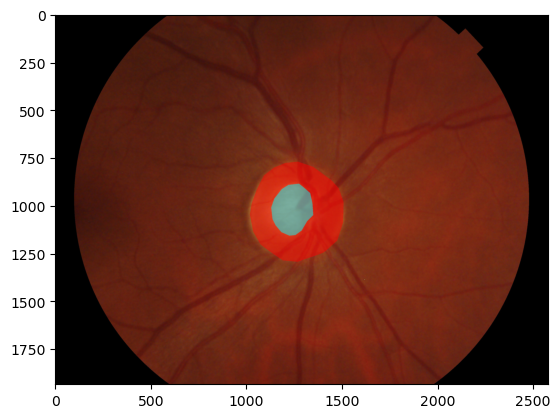

In [10]:
img_name = os.listdir(ROOT_DIR + "FundusImages")[0] # getting image name
img_from_dir = np.array(Image.open(ROOT_DIR + "FundusImages/" + img_name)) # reading image
cont = os.listdir(ROOT_DIR + "ExpertsSegmentations/Contours/") # getting list of countours from dir.
disc = utils.contour_to_mask(cont=cont[0], img_shape=img_shape, abs_path=ROOT_DIR) # getting disc contour
cup = utils.contour_to_mask(cont=cont[2], img_shape=img_shape, abs_path=ROOT_DIR) # getting cup contour
 # applying masks and plotting image
image = utils.apply_mask(image=img_from_dir, mask=cup, color=(1.0, 0.0, 0.0))
image = utils.apply_mask(image=image, mask=disc, color=(0.0, 1.0, 1.0))
plt.imshow(image) 